In [3]:
#Set up data_holder class
import pandas as pd
from collections import namedtuple
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

class data_holder():
    def __init__(self, data_path):
        self.data = pd.read_csv(data_path)
        self.df = self.data.copy()

    def basic_eda(self):
        # count the number of duplicated rows, then grab all NaN (i.e., null) rows
        # in the dataframe
        num_duplicated = self.df.duplicated().sum()
        is_nan = self.df.isnull()
        
        # count the total number of rows that contain *at least one* null value
        num_null_rows = is_nan.any(axis=1).sum()
        
        # count the total number of null values across *all* rows and *all* columns
        # (i.e., a sum of a sum)
        num_total_null = self.df.isnull().sum().sum()

        # construct a named tuple to represent each row in the exploratory data
        # analysis summary
        EDARow = namedtuple("EDARow", ["Name", "Value", "Notes"])

            # build the list of exploratory data analysis rows
        rows = [
            EDARow("Samples", self.df.shape[0], ""),
            EDARow("Features", self.df.shape[1], ""),
            EDARow("Duplicate Rows", num_duplicated, ""),
            EDARow("Rows with NaN", num_null_rows, "{:.2f}% all rows".format(
                (num_null_rows / self.df.shape[0]) * 100)),
            EDARow("Total NaNs", num_total_null, "{:.2f}% feature matrix".format(
                (num_total_null / (self.df.shape[0] * self.df.shape[1])) * 100)),
        ]
            
        # build and return our exploratory data analysis dataframe
        return pd.DataFrame(rows, columns=["Name", "Value", "Notes"])

    def summarize_data(self):
        # initialize a summary dataframe consiting of the original dataframe's
        # column names and data types
        summary = pd.DataFrame(self.df.dtypes, columns=["dtypes"])
        
        # reset the summary index, rename the "index" column to "Name", and then
        # remove the "index" column
        summary = summary.reset_index()
        summary["Name"] = summary["index"]
        summary = summary[["Name", "dtypes"]]
        
        # count the number of (1) null values for each column, and (2) the unique
        # values in each column
        summary["Missing"] = self.df.isnull().sum().values
        summary["Uniques"] = self.df.nunique().values
        
        # return the summary dataframe
        return summary
    
disasters_1970 = data_holder('./DISASTERS/1970-2021_DISASTERS.xlsx - emdat data.csv')
disasters_1900 = data_holder('./DISASTERS/1900_2021_DISASTERS.xlsx - emdat data.csv')



Text(0.5, 1.0, 'Number of Disasters per Country (1970-2021)')

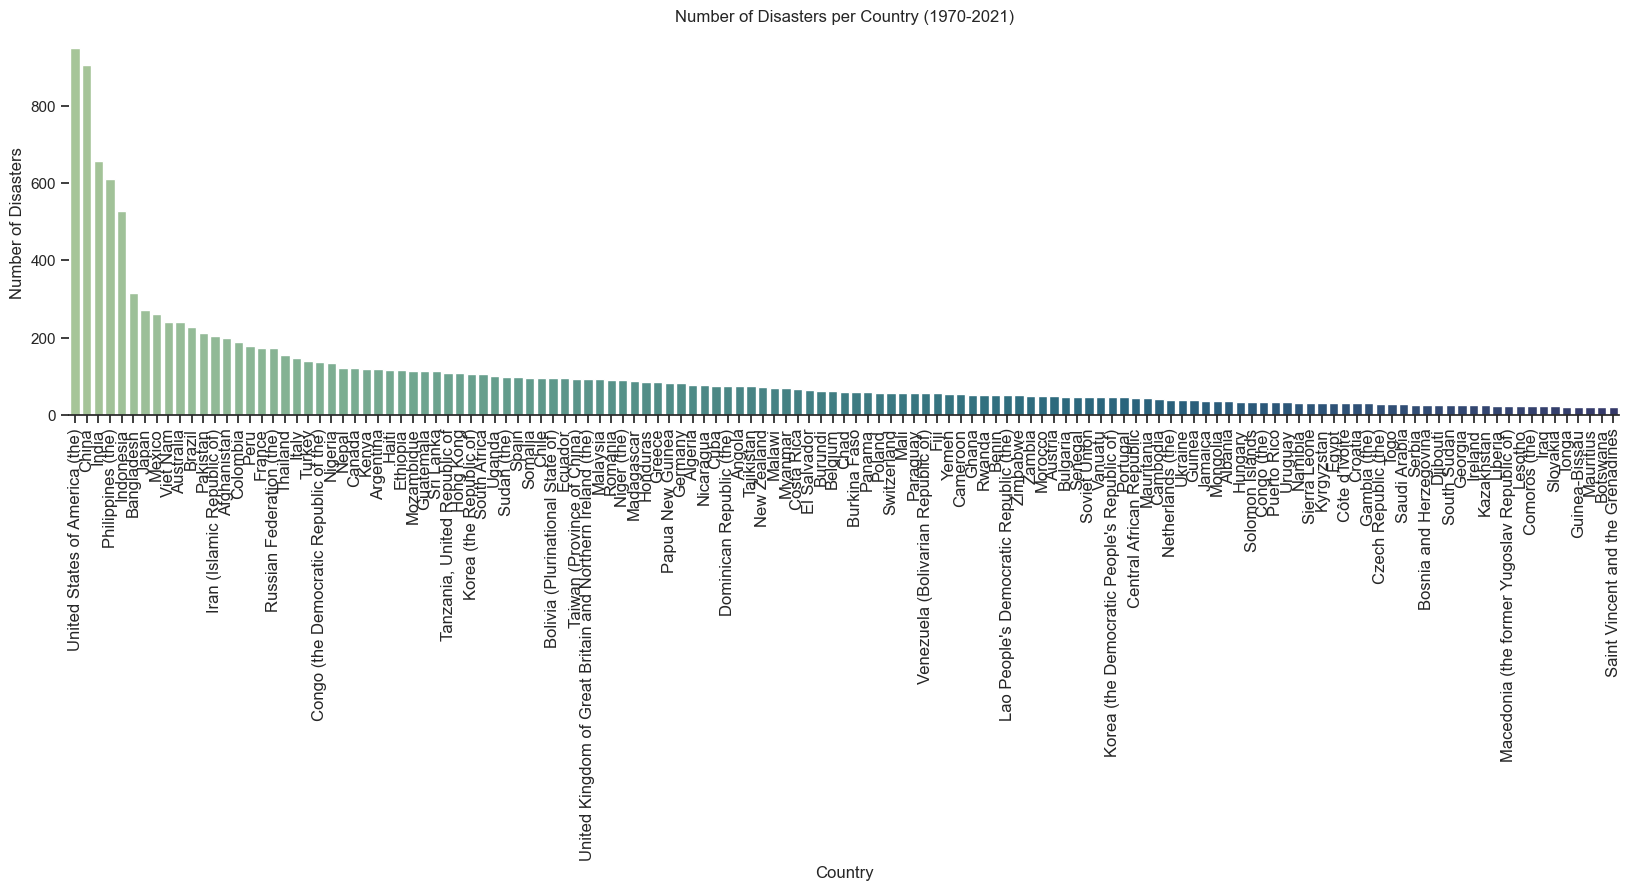

In [4]:
country_counts = disasters_1970.data['Country'].value_counts()
country_counts = country_counts[country_counts >20]

title='Number of Disasters per Country (1970-2021)'
x_label='Country'
y_label="Number of Disasters"
figsize=(20, 5)

# initialize the figure, set the tick information, and update the spines
plt.figure(figsize=figsize)
sns.set_theme(style="ticks", font_scale=1)
plt.xticks(rotation=90, fontsize=12)
sns.despine(top=True, right=True, bottom=False, left=True)

# plot the data
ax = sns.barplot(x=country_counts.index, y=country_counts.values, palette="crest", hue= country_counts.index, legend=False)

# set the x-label, y-label, and title
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
plt.title(title)

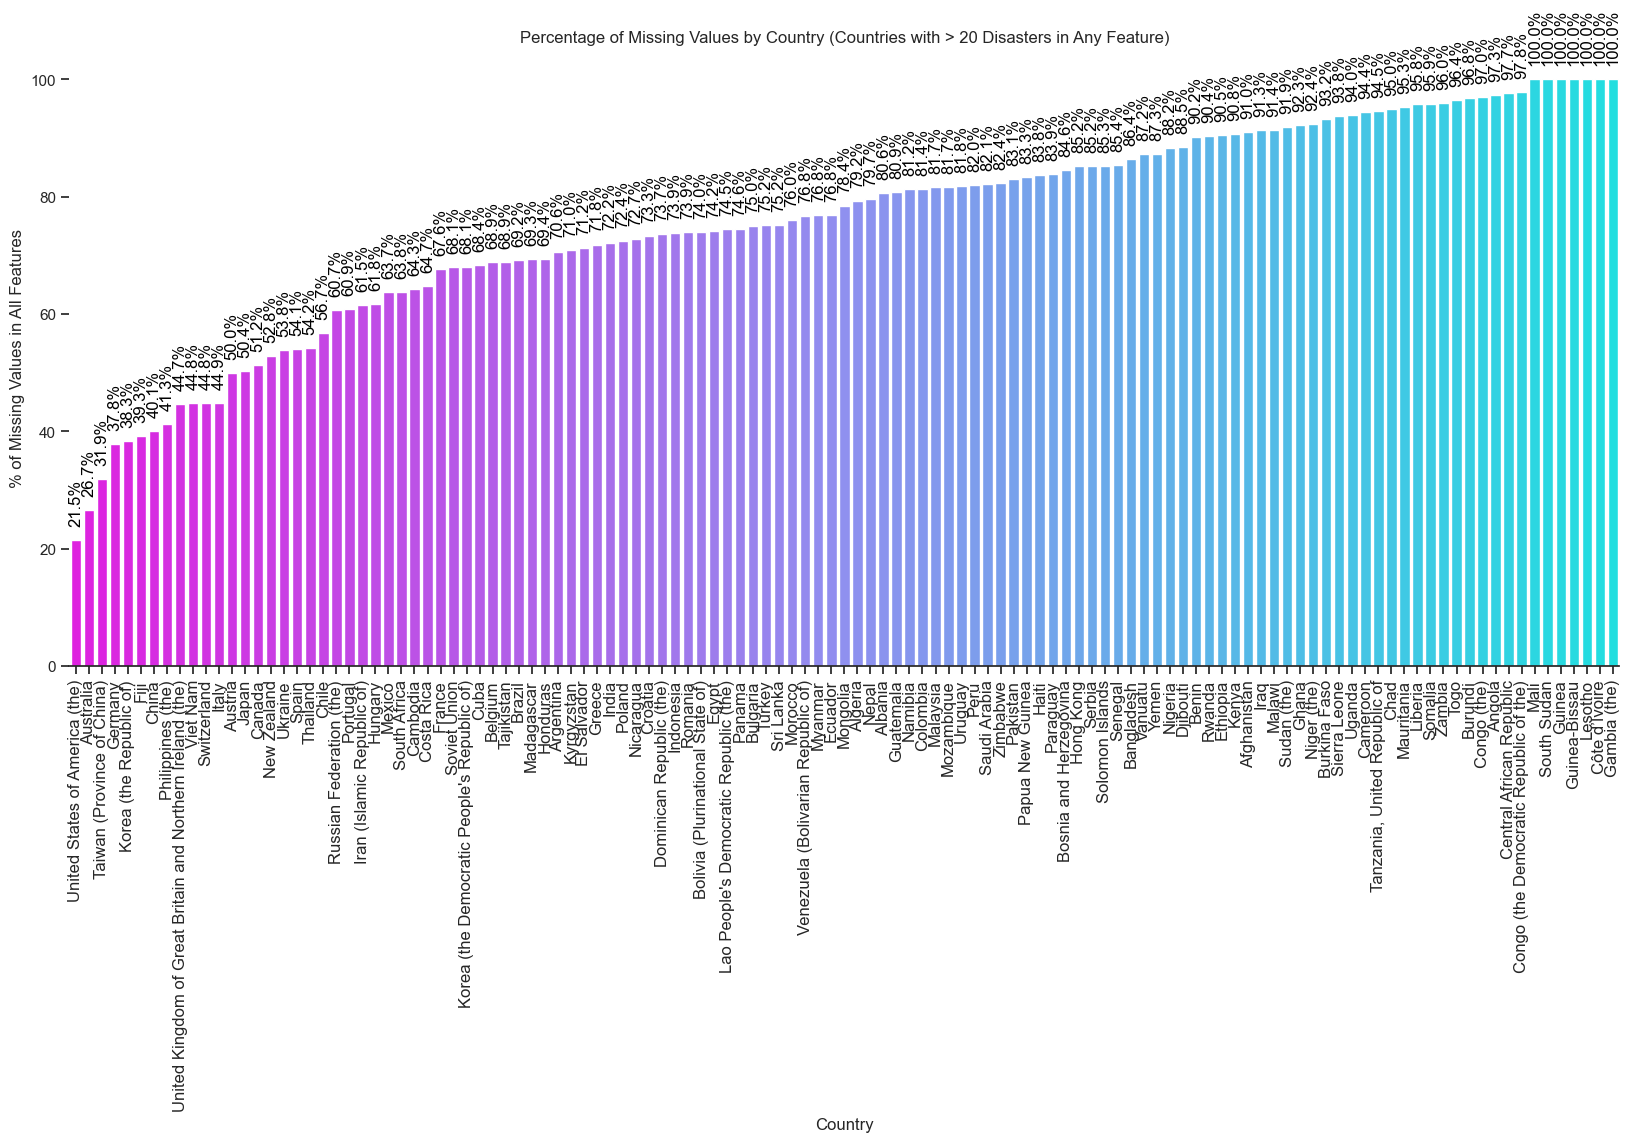

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_missing_values_by_country(df, features, title, x_label="Country", y_label="% of Missing Values in All Features", figsize=(20, 8), min_disasters=20):
    # Filter for countries with a minimum number of records that are missing in all specified features
    country_counts = df.groupby('Country').apply(
        lambda x: (x[features].isna().all(axis=1)).sum(),
        include_groups=False
    )
    countries_with_min_disasters = country_counts[country_counts > min_disasters].index
    filtered_df = df[df['Country'].isin(countries_with_min_disasters)]
    
    # Calculate the percentage of records missing in all specified features for each country
    missing_data = filtered_df.groupby('Country').apply(
        lambda x: (x[features].isna().all(axis=1)).mean() * 100,
        include_groups=False)
    
    # Sort by ascending order (least missing values in all features first)
    missing_data_sorted = missing_data.sort_values()
    
    # Initialize the figure
    plt.figure(figsize=figsize)
    sns.set_theme(style="ticks", font_scale=1)
    plt.xticks(rotation=90, fontsize=12)
    sns.despine(top=True, right=True, bottom=False, left=True)
    
    # Plot the data
    ax = sns.barplot(x=missing_data_sorted.index, y=missing_data_sorted.values, palette="cool_r", hue=missing_data_sorted.index, legend=False)
    
    # Set labels and title
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.title(title)
    
    # Annotate each bar with the percentage of missing values
    for (p, perc) in zip(ax.patches, missing_data_sorted):
        ax.annotate(
            "{:.1f}%".format(perc),
            (p.get_x() + (p.get_width() / 2.0), p.get_height()),
            ha="center",
            va="bottom",
            rotation="vertical",
            color="black",
            xytext=(0, 10),
            textcoords="offset points"
        )

plot_missing_values_by_country(
    disasters_1970.data,
    features=["Total Damages ('000 US$)", "Reconstruction Costs ('000 US$)", "Insured Damages ('000 US$)"],
    title="Percentage of Missing Values by Country (Countries with > 20 Disasters in Any Feature)"
)


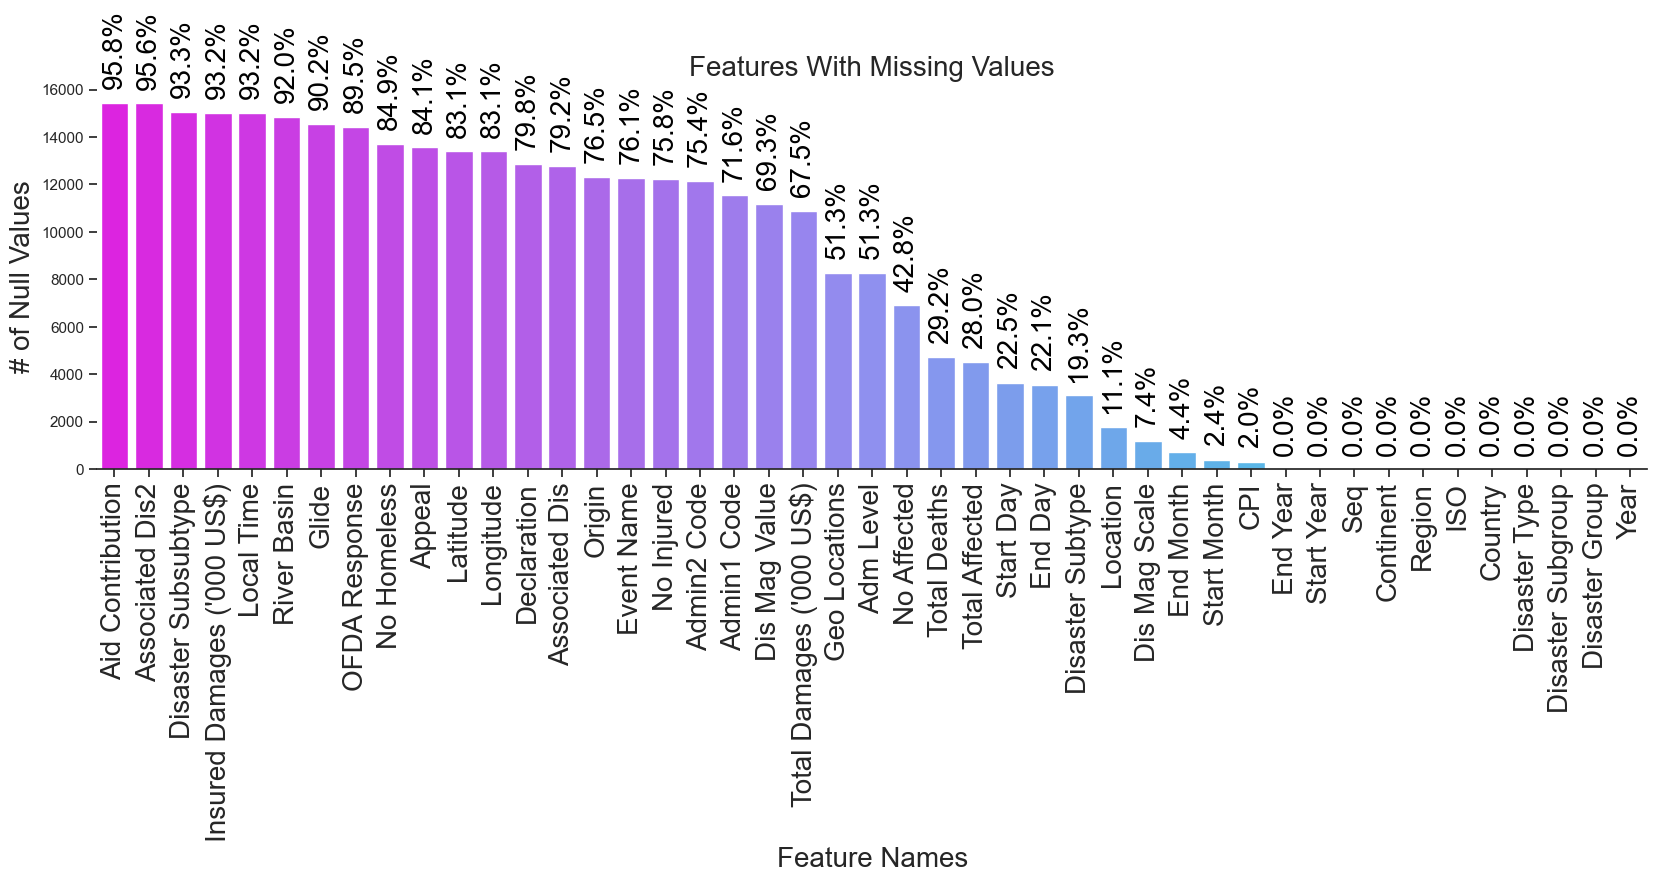

In [11]:
def plot_null_columns(
    df,
    title,
    x_label="Feature Names",
    y_label="# of Null Values",
    figsize=(20, 5)
):
    # count the number of times a given column has a null value
    null_cols = df.isnull().sum().sort_values(ascending=False)
    
    fontsize_titles = 30
    fontsize = 20
    # initialize the figure, set the tick information, and update the spines
    plt.figure(figsize=figsize)
    sns.set_theme(style="ticks", font_scale=1)
    plt.xticks(rotation=90, fontsize=fontsize)
    sns.despine(top=True, right=True, bottom=False, left=True)

    # plot the data
    ax = sns.barplot(x=null_cols.index, y=null_cols, palette="cool_r", hue=null_cols.index, legend=False)

    # set the x-label, y-label, and title
    ax.set_xlabel(x_label, fontsize=fontsize_titles)
    ax.set_ylabel(y_label, fontsize=fontsize_titles)
    plt.title(title, fontsize=fontsize_titles)

    # loop over the patches and null column counts
    for (p, count) in zip(ax.patches, null_cols):
        # compute the percentage of the number of rows that have a null value
        # for the current column
        ax.annotate(
            "{:.1f}%".format((count / df.shape[0]) * 100),
            (p.get_x() + (p.get_width() / 2.0), abs(p.get_height())),
            ha="center",
            va="bottom",
            rotation="vertical",
            color="black",
            xytext=(0, 10),
            textcoords="offset points",
            fontsize=fontsize
        )

# plot the null column counts within the dataset
plot_null_columns(disasters_1900.df, "Features With Missing Values")
